# PETITE Tutorial
Authors: Nikita Blinov (York U.), Patrick J. Fox (Fermilab), Kevin J. Kelly (Texas A&M), Pedro A. N. Machado (Fermilab), and Ryan Plestid (Caltech)

PETITE is a simple, lightweight, toy Monte Carlo that generates realistic electromagnetic showers, with or without new physics.
Currently, dark photons with pure vector couplins are incorporated in PETITE.

PETITE includes explicit simulation of (we denote nuclei by their electric charge $Z$)

* Bremsstrahlung  $e^\pm Z \rightarrow e^\pm \gamma Z$. 
* Pair production $\gamma Z \rightarrow e^+ e^- Z$. 
* Compton scattering $\gamma e^- \rightarrow  \gamma e^-$
* Pair-annihilation $e^+ e^- \rightarrow \gamma\gamma$ 
* Moller Scattering $e^- e^- \rightarrow e^- e^-$
* Bhabha Scattering $e^+ e^- \rightarrow e^+ e^-$

and implicit simulation of 

* Multiple Coulomb scattering
* Energy loss by ionization 

${\bf Dependencies}$: numpy, vegas, pickle, cProfile, tqdm, scipy

${\bf Version~ requirements}$: numpy 1.24  ,  python3.xx with xx$\geq$9.

${\bf Directory~structure}$: This notebook assumes that within a PETITE home directory there is folder containing dictionaries, and that within that folder the following files exist 

* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/sm_xsec.pkl
* $\verb|<PETITE_home_dir>|$/$\verb|<dictionary_dir>|$/sm_maps.pkl

You can check versions with the code below and adjust if necessary.

In this tutorial you will learn how to 
1. Initialize PETITE
2. Generate a standard electromagnetic shower
3. Generate a shower with a dark photon
4. Analyze the accept/reject method used by PETITE, based on precomputed shower samples
5. Understand how to generate novel shower samples.

In [9]:
# Force reload (if changes have been made to the module)
%load_ext autoreload
%autoreload 2

# Initialization of the tutorial
from platform import python_version
print("Python version: ", python_version())

import numpy
print("Numpy version: ", numpy.__version__)

import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]

print("PETITE home directory:", PETITE_home_dir)
# folder where VEGAS dictionaries are stored
# dictionary_dir = "data/VEGAS_dictionaries/"
dictionary_dir = "data_400GeV/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python version:  3.12.7
Numpy version:  1.26.4
PETITE home directory: c:\Users\kevin\OneDrive - Loyola University Chicago\Code\Python\PETITE\PETITE\


### Load in dependencies and set font styles

In [10]:
from PETITE.shower import *
import pickle as pk
from matplotlib import pyplot as plt
from tqdm import tqdm
#from tqdm.notebook import tqdm

import matplotlib

from matplotlib.font_manager import FontProperties
from matplotlib.ticker import FixedLocator, MaxNLocator
import cProfile
profile = cProfile.Profile()
import pstats

font0 = FontProperties()
font = font0.copy()
font.set_size(24)
font.set_family('serif')
labelfont=font0.copy()
labelfont.set_size(20)
labelfont.set_weight('bold')
legfont=font0.copy()
legfont.set_size(18)
legfont.set_weight('bold')


def set_size(w,h, ax=None):
    """ Helper function to set figure size.
        Input:
            w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

####  Outline

- Generating standard model shower
- Generating dark photon shower
- Plotting acceptance
- Plotting individual processes
- Generating novel shower samples
- Analyzing accept-reject method in PETITE

## Shower production with PETITE

The primary purpose of PETITE is to produce realistic electromagnetic showers with a lightweight, reasonably fast, python-native code base. We illustrate its performance below. 

We will shoot a 10 GeV particle incident on either lead or graphite. Particles are specified by their PDG codes (see e.g. https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf). Units in PETITE are GeV, meters, and radians.

* ${\rm PDG}(e^\pm)=\pm11$ 
* ${\rm PDG}(\gamma)~~=+22$ 


In [11]:
E0 = 10. # energy of incident particle in GeV

# Define incident electron
px, py, pz = 0, 0, np.sqrt(E0**2 - 0.000511**2)

# dictionary with particle properties
# The crucial keys are 'PID' and 'ID', others are for efficient bookkeeping
particle_dict = {'PID':11, 'ID':0, 'generation_number':0, 'generation_process':'Input'}
p0 = Particle([E0, px, py, pz], [0,0,0], particle_dict)

In [12]:
# Shower(directory, material, minimum_energy)
sGraphite = Shower(PETITE_home_dir+dictionary_dir, "graphite", 0.010)
sLead = Shower(PETITE_home_dir+dictionary_dir, "lead", 0.010)

# Generate standard shower for graphite and lead, let's turn on verbosity to see what's going on
standard_shower_graphite = sGraphite.generate_shower(p0, VB=True)
standard_shower_lead = sLead.generate_shower(p0, VB=True)

Starting shower, initial particle with ID Info
{'PID': 11, 'ID': 0, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.000511, 'stability': 'stable', 'production_time': 0.0, 'decay_time': 0.0, 'interaction_time': 0.0}
Initial four-momenta:
[10.          0.          0.          9.99999999]
Starting shower, initial particle with ID Info
{'PID': 11, 'ID': 0, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.000511, 'stability': 'stable', 'production_time': 0.0, 'decay_time': 0.0, 'interaction_time': 0.0}
Initial four-momenta:
[10.          0.          0.          9.99999999]


The shower is now generated. The object standard_shower_graphite is a list of particles generated throughout the shower. We can look at some of their properties.

Total number of particles:  736
Number of (photons, electrons, positrons):  175 391 170


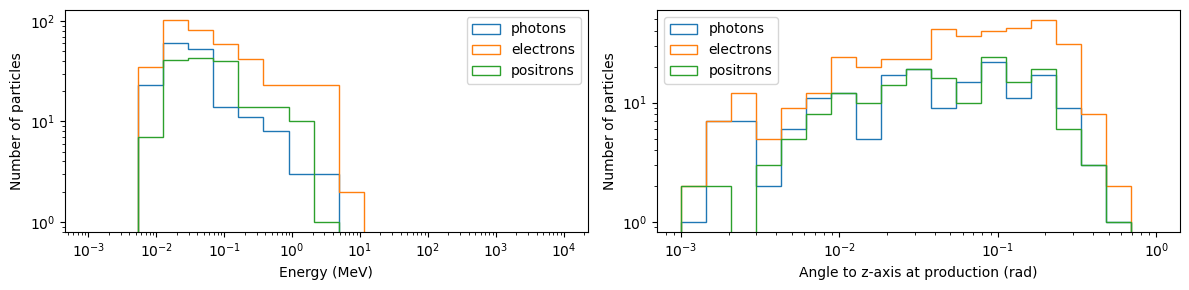

In [13]:
# Let's look at different particles in the shower and their properties.
print('Total number of particles: ', len(standard_shower_graphite))

photons = [p for p in standard_shower_graphite if p.get_pid() == 22]
electrons = [p for p in standard_shower_graphite if p.get_pid() == 11]
positrons = [p for p in standard_shower_graphite if p.get_pid() == -11]
print('Number of (photons, electrons, positrons): ', len(photons), len(electrons), len(positrons))

# Let's look at the energy and angle spectra of all particles.
# Let's make these plots in log-log scale, all particles go in the same plot, energy goes in the left panel, while angle goes in the right panel.
bins_energy = np.logspace(-3, 4, 20)
bins_angle = np.logspace(-3, 0, 20) # radians
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist([p.get_p0()[0] for p in photons], bins=bins_energy, histtype='step', label='photons')
plt.hist([p.get_p0()[0] for p in electrons], bins=bins_energy, histtype='step', label='electrons')
plt.hist([p.get_p0()[0] for p in positrons], bins=bins_energy, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of particles')
plt.legend()
plt.subplot(122)
plt.hist([p.get_angle_to_z_0() for p in photons], bins=bins_angle, histtype='step', label='photons')
plt.hist([p.get_angle_to_z_0() for p in electrons], bins=bins_angle, histtype='step', label='electrons')
plt.hist([p.get_angle_to_z_0() for p in positrons], bins=bins_angle, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle to z-axis at production (rad)')
plt.ylabel('Number of particles')
plt.legend()
plt.tight_layout()
plt.show()

Total number of particles:  1502
Number of (photons, electrons, positrons):  306 631 565


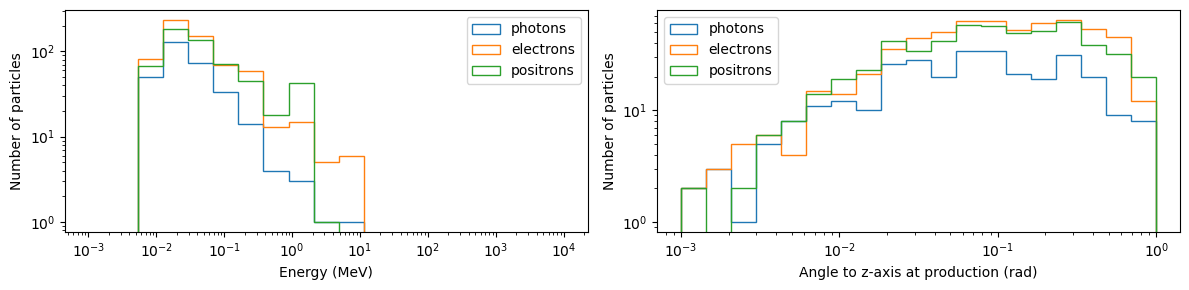

In [14]:
#Let's repeat the above but looking at the shower through lead instead of graphite:

print('Total number of particles: ', len(standard_shower_lead))
photons = [p for p in standard_shower_lead if p.get_pid() == 22]
electrons = [p for p in standard_shower_lead if p.get_pid() == 11]
positrons = [p for p in standard_shower_lead if p.get_pid() == -11]
print('Number of (photons, electrons, positrons): ', len(photons), len(electrons), len(positrons))
# Let's look at the energy and angle spectra of all particles.
# Let's make these plots in log-log scale, all particles go in the same plot, energy goes in the left panel, while angle goes in the right panel.
bins_energy = np.logspace(-3, 4, 20)
bins_angle = np.logspace(-3, 0, 20) # radians
plt.figure(figsize=(12, 3))
plt.subplot(121)
plt.hist([p.get_p0()[0] for p in photons], bins=bins_energy, histtype='step', label='photons')
plt.hist([p.get_p0()[0] for p in electrons], bins=bins_energy, histtype='step', label='electrons')
plt.hist([p.get_p0()[0] for p in positrons], bins=bins_energy, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Number of particles')
plt.legend()
plt.subplot(122)
plt.hist([p.get_angle_to_z_0() for p in photons], bins=bins_angle, histtype='step', label='photons')
plt.hist([p.get_angle_to_z_0() for p in electrons], bins=bins_angle, histtype='step', label='electrons')
plt.hist([p.get_angle_to_z_0() for p in positrons], bins=bins_angle, histtype='step', label='positrons')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Angle to z-axis at production (rad)')
plt.ylabel('Number of particles')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
print(standard_shower_graphite[0].get_p0())

[10.          0.          0.          9.99999999]


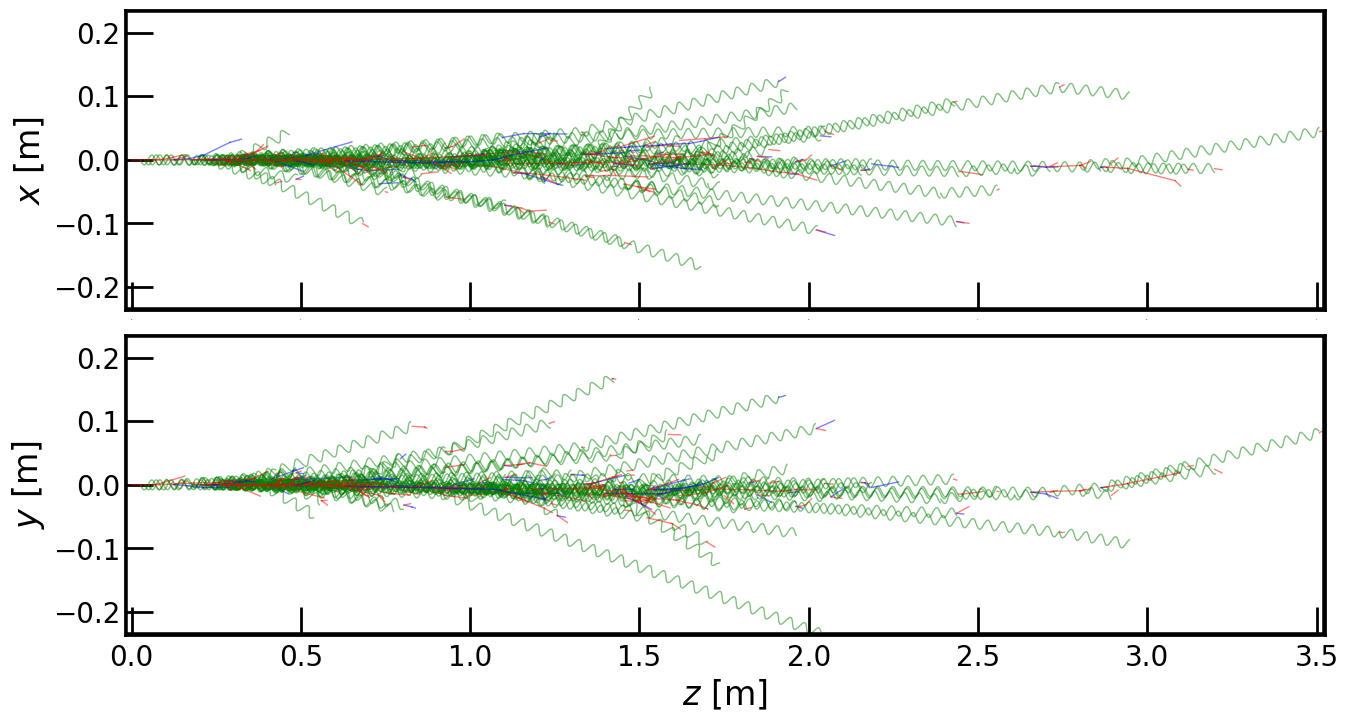

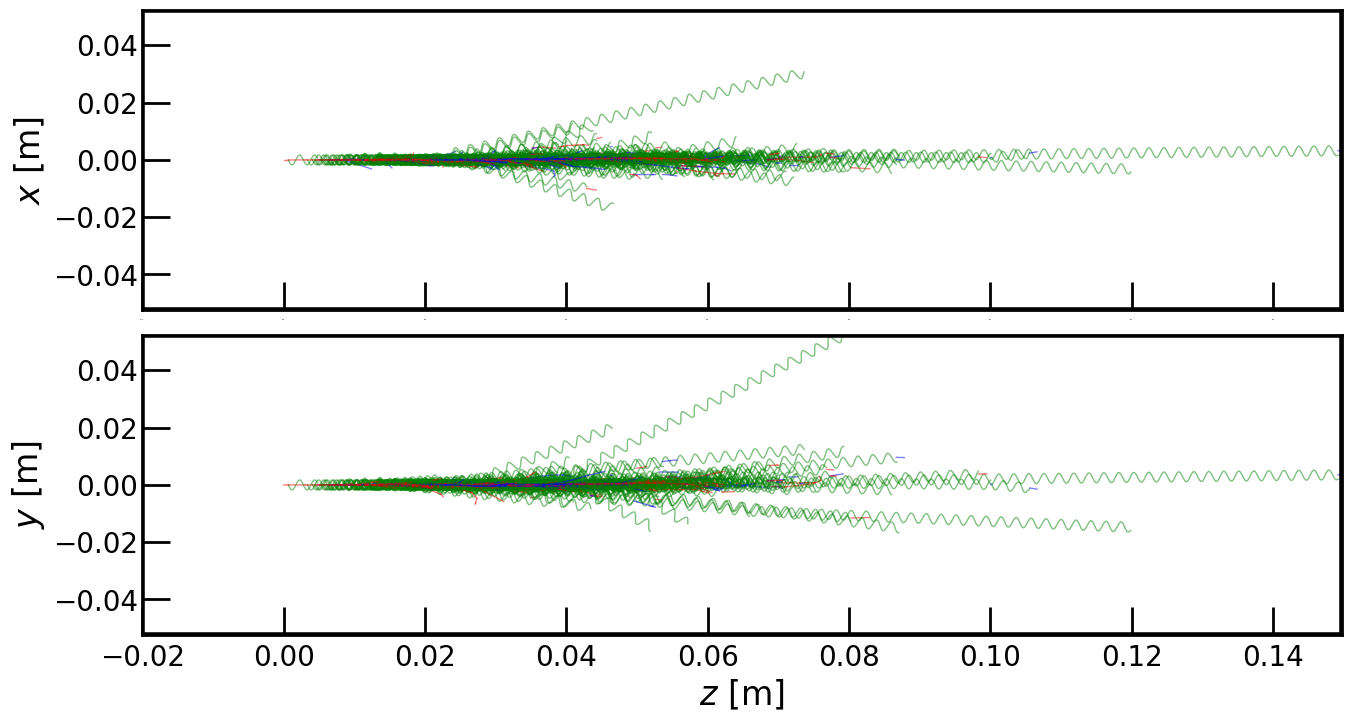

In [16]:
# We can also see the shower display for both graphite and lead
event_display(standard_shower_graphite)
event_display(standard_shower_lead)

Pretty neat, no? Notice the difference in the z-range, which is just a consequence of the smaller mean free path in lead.

####  We looked at two shower objects, one with a graphite target and one with lead. Both track down to minimum energies of 10 MeV

The minimum energy in the shower dictates the run-time. As one attempts to simulate lower-threshold IR physics, the computational cost increases exponentially. The number of low energy particles proliferates and one encounters many compton scatters.  10 MeV allows for reasonable simulation speed. 

Pre-loaded materials are lead and graphite, but other materials can be included straightforwardly running other scripts in the PETITE utilities folder

## Accept/reject in PETITE
PETITE usese VEGAS intergrator objects pre-trained on a grid of incident particle energies. During a shower the nearest energy with "good coverage" is used to draw samples, and accept reject is performed with the diffential cross section at the true physical energy. 

As an illustration we set an incident electron energy at $E_{e} = 1.0 ~{\rm GeV}$, and sample from several integrators trained at nearby energies for the bremsstrahlung process $e Z \rightarrow e Z \gamma$. 

In [17]:
sample_list = sGraphite._loaded_samples
sample_list['Brem'][78] # 78th sample for bremsstrahlung for electron around 1GeV

[1.071241121564173,
 {'neval': 300,
  'max_F': {'graphite': 558.8125376592358,
   'lead': 97829.6934677965,
   'iron': 10254.643906897452,
   'aluminum': 2598.8004637673725,
   'molybdenum': 26393.330396569465},
  'adaptive_map': <vegas._vegas.AdaptiveMap at 0x1d6aca3c4a0>,
  'Eg_min': 0.001,
  'Ee_min': 0.005}]

In [18]:
len(sample_list['Brem'])

150

In [19]:
sample_list = sGraphite._loaded_samples
energies = sample_list["Brem"][0:]
energies = np.array([x[0] for x in energies])

Einc = 1.0
LU_Key = np.argmin(np.abs(energies - Einc)) + 1

print(LU_Key)

78


In [20]:
number_of_samples = 1000
energy_in = 1.0

xs0 = []
trials0 = []
for k in tqdm(range(int(number_of_samples))):
    s0 = sGraphite.draw_sample(energy_in, LU_Key=74, process='Brem', VB=True)
    xs0.append(s0[0])
    trials0.append(s0[-1])

xs1 = []
trials1 = []
for k in tqdm(range(int(number_of_samples))):
    s0 = sGraphite.draw_sample(energy_in, LU_Key=77, process='Brem', VB=True)
    xs1.append(s0[0])
    trials1.append(s0[-1])

xs2 = []
trials2 = []
for k in tqdm(range(int(number_of_samples))):
    s0 = sGraphite.draw_sample(energy_in, LU_Key=81, process='Brem', VB=True)
    xs2.append(s0[0])
    trials2.append(s0[-1])

xs3 = []
trials3 = []
for k in tqdm(range(int(number_of_samples))):
    s0 = sGraphite.draw_sample(energy_in, process='Brem', LU_Key=-1, VB=True)
    xs3.append(s0[0])
    trials3.append(s0[-1])

100%|██████████| 1000/1000 [00:02<00:00, 448.66it/s]


In [21]:
xs0

[0.42091286732569927,
 0.03500390682334918,
 8.230440236649185e-05,
 0.05484550671824286,
 0.03141171236068385,
 0.006181854546446164,
 5.784946322188673e-05,
 0.04459791516495397,
 0.004263281904318874,
 5.169964914244336e-05,
 0.0015817622790459116,
 0.08937447600053983,
 0.2619461426822894,
 0.21534799861208076,
 0.049046749600782424,
 0.0027969333146836985,
 0.03480698171285378,
 0.008436450168400647,
 0.020660885794747563,
 0.0020447657480628305,
 0.06833240172609575,
 0.12998057594772175,
 0.08393022124530074,
 0.019853317352550085,
 0.002578216592184797,
 0.0009526688671026882,
 0.23252011605922868,
 0.716455180699854,
 0.021624839196560344,
 0.01172583487291509,
 0.00013285972896084347,
 0.32727215035430623,
 0.38940267691916064,
 0.6497220845584681,
 0.004695796742817582,
 0.0037077903171336573,
 0.01901951537109226,
 0.05388116571850351,
 0.38484506105200067,
 0.25463515452215746,
 0.022656353964590627,
 0.01814033558944774,
 0.0020987815549175105,
 0.05345290479368997,
 0.06

### Compare efficiency of sampling for different nearby energies

Number of trials:  1000 1000 1000 1000


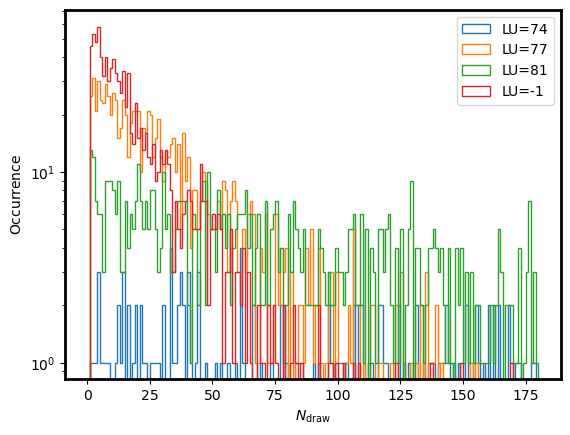

In [22]:
bin_space = np.linspace(0, 180, 181)
plt.hist(trials0, bins=bin_space, histtype='step', lw=1, label='LU=74')
plt.hist(trials1, bins=bin_space, histtype='step', lw=1, label='LU=77')
plt.hist(trials2, bins=bin_space, histtype='step', lw=1, label='LU=81')
plt.hist(trials3, bins=bin_space, histtype='step', lw=1, label='LU=-1')
plt.gca().set_xlabel(r"$N_{\rm draw}$")
plt.gca().set_ylabel(r"$\mathrm{Occurrence}$")
plt.gca().set_yscale('log')
# show labels
plt.legend()
# print number of trials
print("Number of trials: ", len(trials0), len(trials1), len(trials2), len(trials3))

### Check distributions to see if they are insensitive to choice of integrator object

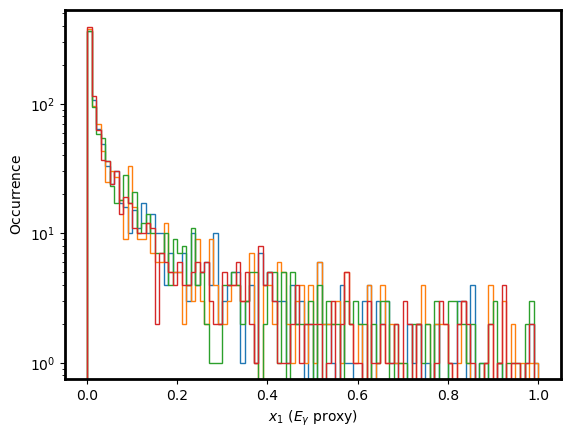

In [23]:
plt.hist(xs0, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.hist(xs1, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.hist(xs2, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.hist(xs3, bins=np.linspace(0, 1, 101), histtype='step', lw=1)
plt.gca().set_xlabel(r"$x_1\ (E_{\gamma}\ \rm{proxy})$")
plt.gca().set_ylabel(r"$\mathrm{Occurrence}$")
plt.gca().set_yscale('log')

## Use of rotated coordinates

PETITE uses small angle variables (see e.g. sections 92-94 of Landau and Lifshitz Vol 4). However low-momentum transfers occur along a correlated "ridge" in these variables. To improve performance we have rotated angles. 

We illustrate the difference in performance, and benchmark total cross sections computed using the VEGAS integrators below. 

In [24]:
xsec_dicts = pk.load(open(PETITE_home_dir+dictionary_dir+"sm_xsec.pkl", "rb"))

### Pair production

Cross sections are material dependent due to $Z^2$ scaling, but also due to atomic form factors (see e.g.\ Tsai Rev. Mod. Phys. (1974). 

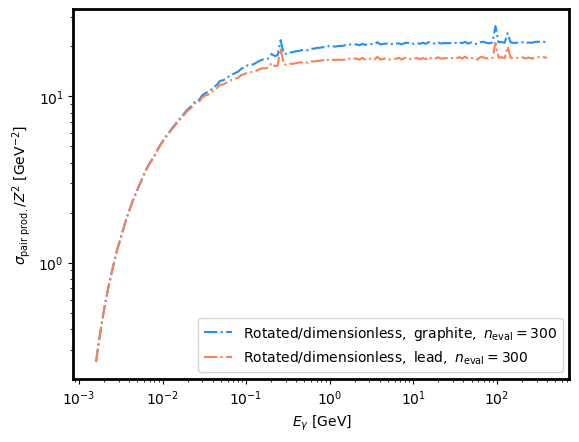

In [25]:
plt.plot(np.transpose(xsec_dicts['PairProd']['graphite'])[0], np.transpose(xsec_dicts['PairProd']['graphite'])[1]/6**2, color='dodgerblue', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ graphite,\ }n_{\rm eval}=300$")
plt.plot(np.transpose(xsec_dicts['PairProd']['lead'])[0], np.transpose(xsec_dicts['PairProd']['lead'])[1]/82**2, color='coral', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ lead,\ }n_{\rm eval}=300$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{\gamma}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma_{\rm pair\ prod.}/Z^2\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


### Bremsstrahlung

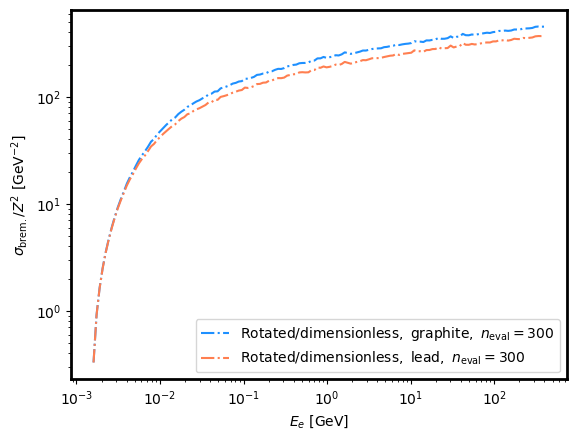

In [26]:
plt.plot(np.transpose(xsec_dicts['Brem']['graphite'])[0], np.transpose(xsec_dicts['Brem']['graphite'])[1]/6**2, color='dodgerblue', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ graphite,\ }n_{\rm eval}=300$")
plt.plot(np.transpose(xsec_dicts['Brem']['lead'])[0], np.transpose(xsec_dicts['Brem']['lead'])[1]/82**2, color='coral', ls='-.', label=r"$\mathrm{Rotated/dimensionless,\ lead,\ }n_{\rm eval}=300$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{e}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma_{\rm brem.}/Z^2\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


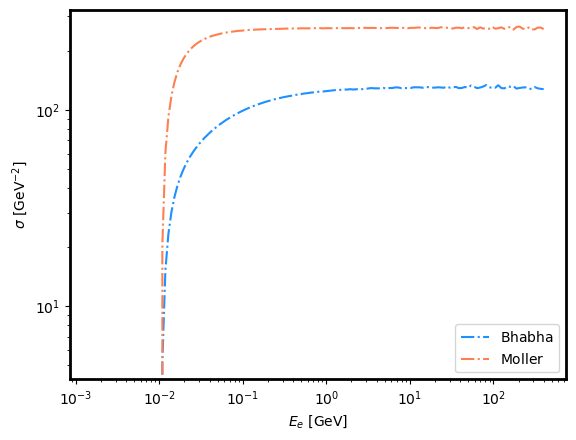

In [27]:
plt.plot(np.transpose(xsec_dicts['Bhabha']['graphite'])[0], np.transpose(xsec_dicts['Bhabha']['graphite'])[1], color='dodgerblue', ls='-.', label=r"$\mathrm{Bhabha}$")
plt.plot(np.transpose(xsec_dicts['Moller']['graphite'])[0], np.transpose(xsec_dicts['Moller']['graphite'])[1], color='coral', ls='-.', label=r"$\mathrm{Moller}$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{e}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


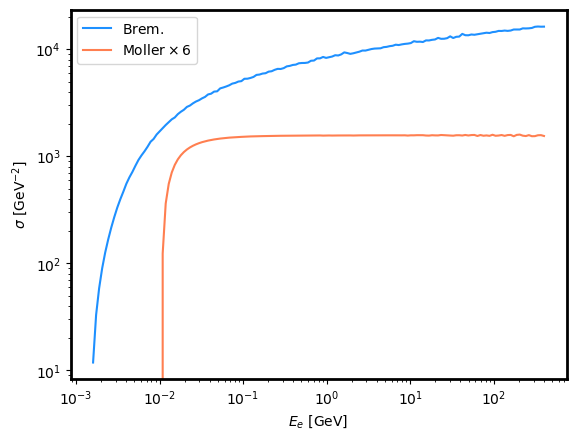

In [28]:
plt.plot(np.transpose(xsec_dicts['Brem']['graphite'])[0], np.transpose(xsec_dicts['Brem']['graphite'])[1], color='dodgerblue', ls='-', label=r"$\mathrm{Brem.}$")
plt.plot(np.transpose(xsec_dicts['Moller']['graphite'])[0], np.transpose(xsec_dicts['Moller']['graphite'])[1]*6, color='coral', ls='-', label=r"$\mathrm{Moller}\times 6$")

plt.legend(loc='best')

plt.gca().set_xlabel(r"$E_{e}\ [\mathrm{GeV}]$")
plt.gca().set_ylabel(r"$\sigma\ [\mathrm{GeV^{-2}}]$")

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')


## Ensemble shower production with PETITE

Expanding on the above, we can produce many showers produced by the same incident particle and analyze statistics of shower ensembles. The flexibility and speed of PETITE is a priority in this context, and so we first explore the timing of shower generation.

Check shower timing

In [29]:
def slowShower():
    s0 = sGraphite.generate_shower(p0, VB=True)
    return

We use the package cProfile to return useful information on the runtime. This is helpful if one would like to change $E_{\rm min}$ which can slow down the code. The output below is helpful in diagnosing bottlenecks etc.

In [30]:
profileSS = cProfile.Profile()
profileSS.runcall(slowShower)
psSS = pstats.Stats(profileSS)
psSS.print_stats()

Starting shower, initial particle with ID Info
{'PID': 11, 'ID': 0, 'parent_PID': 22, 'parent_ID': -1, 'generation_number': 0, 'generation_process': 'Input', 'weight': 1.0, 'mass': 0.000511, 'stability': 'stable', 'production_time': 0.0, 'decay_time': 0.0, 'interaction_time': 0.0}
Initial four-momenta:
[10.          0.          0.          9.99999999]
         1641276 function calls (1641216 primitive calls) in 5.110 seconds

   Random listing order was used

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        8    0.000    0.000    0.000    0.000 c:\Users\kevin\anaconda\Lib\enum.py:1551(__or__)
        6    0.000    0.000    0.000    0.000 c:\Users\kevin\anaconda\Lib\enum.py:1562(__and__)
        5    0.000    0.000    0.000    0.000 c:\Users\kevin\anaconda\Lib\threading.py:1222(is_alive)
        5    0.000    0.000    0.000    0.000 c:\Users\kevin\anaconda\Lib\threading.py:1155(_wait_for_tstate_lock)
        4    0.000    0.000    0.000    0.000 c:\Users\k

## Tests and validations

Generate some ensembles of brem./pair production samples, with 10 GeV particles injected and check basic properties of distributions

In [31]:
particle_dict_gamma = {'PID':22, 'ID':0, 'generation_number':0, 'generation_process':'Input'}
p0G = Particle([E0, 0, 0, E0], [0,0,0], particle_dict_gamma)

In [ ]:
nSamp = 20000 # make this larger if you want more precision (it is slower though)...
s0 = np.array([sGraphite.sample_scattering(p0, process="Brem", VB=True) for i in tqdm(range(nSamp))])
s0G = np.array([sGraphite.sample_scattering(p0G, process="PairProd", VB=True) for i in tqdm(range(nSamp))])

 17%|█▋        | 3416/20000 [04:56<27:33, 10.03it/s]  

In [ ]:
Es = np.array([s[1].get_p0()[0] for s in s0])
EsE = np.array([s[0].get_p0()[0] for s in s0])

EsG = np.array([s[1].get_p0()[0] for s in s0G])
EsGP = np.array([s[0].get_p0()[0] for s in s0G])

### Photon and electron distribution from first scatter

We expect a flat photon distribution in log-space 

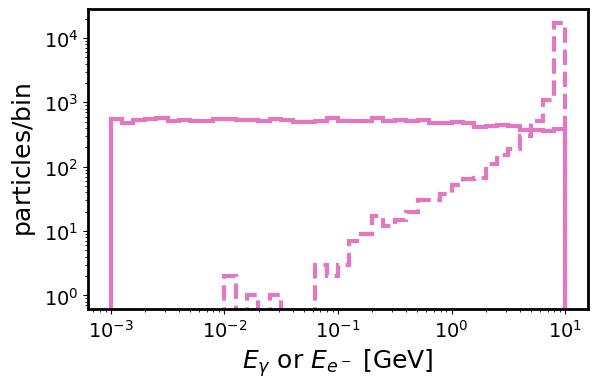

In [ ]:
b0 = np.logspace(-3, 1, 41)

dens = False
plt.hist(Es, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-', label=r"$\mathrm{SM,\ Ryan\ Approach}$")
plt.hist(EsE, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_\gamma\ \mathrm{or}\ E_{e^-}\ [\mathrm{GeV}]$", fontsize=18)
plt.gca().set_ylabel(r"$\mathrm{particles/bin}$", fontsize=18)
[l.set_size(14) for l in plt.gca().get_xticklabels()]
[l.set_size(14) for l in plt.gca().get_yticklabels()]

set_size(5.0, 3.0)


### Look at angular distributions of outgoing particles from bremsstrahlung/pair production in terms of their $p_T/p_z$

In [ ]:
pTpz = np.array([(s[1].get_p0()[3]/np.sqrt(s[1].get_p0()[1]**2 + s[1].get_p0()[2]**2))**(-1) for s in s0])
pTpzE = np.array([(s[0].get_p0()[3]/np.sqrt(s[0].get_p0()[1]**2 + s[0].get_p0()[2]**2))**(-1) for s in s0])

pTpzG = np.array([(s[1].get_p0()[3]/np.sqrt(s[1].get_p0()[1]**2 + s[1].get_p0()[2]**2))**(-1) for s in s0G])
pTpzGP = np.array([(s[0].get_p0()[3]/np.sqrt(s[0].get_p0()[1]**2 + s[0].get_p0()[2]**2))**(-1) for s in s0G])

In [ ]:
pT = np.array([(1/np.sqrt(s[1].get_p0()[1]**2 + s[1].get_p0()[2]**2))**(-1) for s in s0])
pTE = np.array([(1/np.sqrt(s[0].get_p0()[1]**2 + s[0].get_p0()[2]**2))**(-1) for s in s0])

pTG = np.array([(1/np.sqrt(s[1].get_p0()[1]**2 + s[1].get_p0()[2]**2))**(-1) for s in s0G])
pTGP = np.array([(1/np.sqrt(s[0].get_p0()[1]**2 + s[0].get_p0()[2]**2))**(-1) for s in s0G])

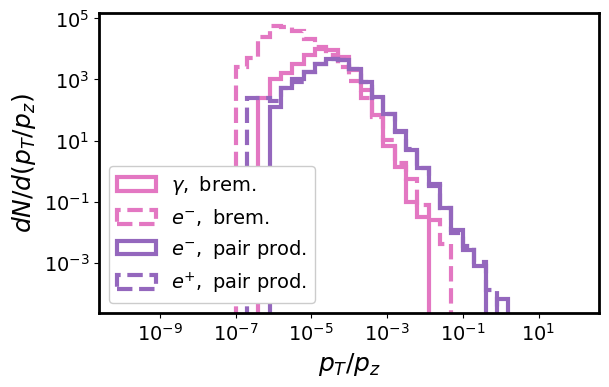

In [ ]:
b0 = np.logspace(-10, 2, 41)

dens = True
plt.hist(pTpz, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-', label=r"$\gamma,\ \rm{brem.}$")
plt.hist(pTpzE, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--', label=r"$e^{-},\ \rm{brem.}$")

plt.hist(pTpzG, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='-', label=r"$e^{-},\ \rm{pair\ prod.}$")
plt.hist(pTpzGP, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='--', label=r"$e^{+},\ \rm{pair\ prod.}$")

plt.gca().legend(loc='best', fontsize=14, framealpha=1.0)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$p_T/p_z$", fontsize=18)
plt.gca().set_ylabel(r"$dN/d(p_T/p_z)$", fontsize=18)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(14) for l in plt.gca().get_xticklabels()]
[l.set_size(14) for l in plt.gca().get_yticklabels()]

set_size(5.0, 3.0)


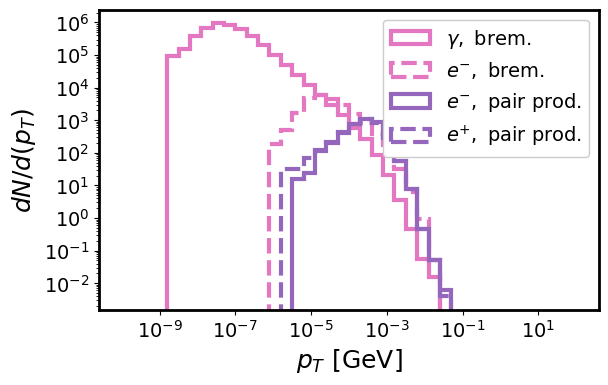

In [ ]:
b0 = np.logspace(-10, 2, 41)

dens = True
plt.hist(pT, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-', label=r"$\gamma,\ \rm{brem.}$")
plt.hist(pTE, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--', label=r"$e^{-},\ \rm{brem.}$")

plt.hist(pTG, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='-', label=r"$e^{-},\ \rm{pair\ prod.}$")
plt.hist(pTGP, bins=b0, histtype='step', lw=3, color='C4', density=dens, ls='--', label=r"$e^{+},\ \rm{pair\ prod.}$")

plt.gca().legend(loc='best', fontsize=14, framealpha=1.0)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$p_T\ [\mathrm{GeV}]$", fontsize=18)
plt.gca().set_ylabel(r"$dN/d(p_T)$", fontsize=18)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(14) for l in plt.gca().get_xticklabels()]
[l.set_size(14) for l in plt.gca().get_yticklabels()]

set_size(5.0, 3.0)


## Outgoing electron/positron energies coming from pair production: should be identical

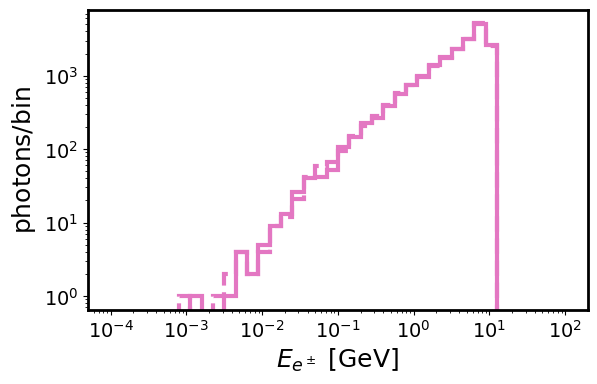

In [ ]:
b0 = np.logspace(-4, 2, 41)

dens=False 

plt.hist(EsG, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='-')
plt.hist(EsGP, bins=b0, histtype='step', lw=3, color='C6', density=dens, ls='--')

#plt.gca().legend(loc=2, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^\pm}\ [\mathrm{GeV}]$", fontsize=18)
plt.gca().set_ylabel(r"$\mathrm{photons/bin}$", fontsize=18)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(14) for l in plt.gca().get_xticklabels()]
[l.set_size(14) for l in plt.gca().get_yticklabels()]

set_size(5.0, 3.0)


### Event-by-event ratio of $E_{e^-}/E_{e^+}$: should be symmetric about 1.

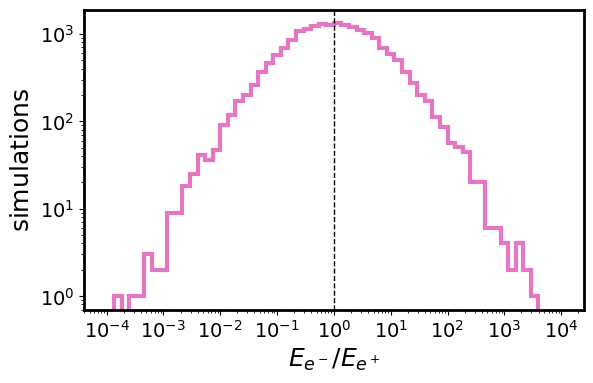

In [ ]:
b0 = np.logspace(-4, 4, 61)

plt.hist(EsG/EsGP, bins=b0, histtype='step', lw=3, color='C6', density=False, ls='-', label=r"$\mathrm{SM,\ Ryan\ Approach}$")

#plt.gca().legend(loc=1, fontsize=16)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel(r"$E_{e^-}/E_{e^+}$", fontsize=18)
plt.gca().set_ylabel(r"$\mathrm{simulations}$", fontsize=18)
#plt.gca().axis([1e-3,100,1e-11,1e-3])
[l.set_size(14) for l in plt.gca().get_xticklabels()]
[l.set_size(14) for l in plt.gca().get_yticklabels()]
plt.gca().axvline(1.0, color='k', lw=1, ls='--')

set_size(5.0, 3.0)


### Asymmetry of the distribution. 

A basic test is distributions should be symmetric under  $e^+\leftrightarrow e^-$. We expect deviations due to statistical flucutations, on the order of $1/\sqrt{N}$ where $N$ is the size of the sample.

In [ ]:
print("Asymmetry", (len(np.where(EsG > E0/2)[0]) - len(np.where(EsG < E0/2)[0]))/len(EsG) ) 
print("Statistical Error:" , 1/np.sqrt(len(EsG)) )


Asymmetry -0.0004
Statistical Error: 0.007071067811865475
